In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import cv2
from matplotlib import pyplot as plt
import os
import numpy as np
import pandas as pd

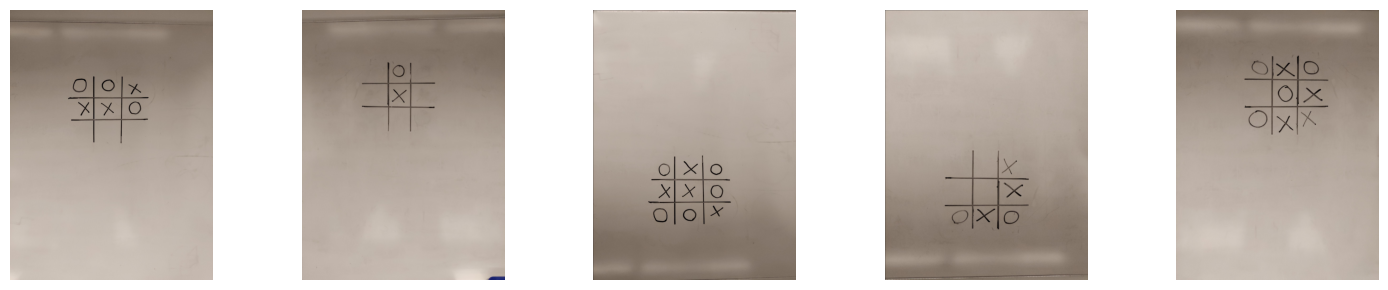

In [ ]:
folder_path = "/content/drive/MyDrive/Digital_Detection/data/train"
image_files = [f for f in os.listdir(folder_path) if f.lower().endswith(".jpg")]

# Number of images to display
num_images = 5
plt.figure(figsize=(15, 3))  # Wide figure for a row of images

for i, img_file in enumerate(image_files[:num_images]):
    img_path = os.path.join(folder_path, img_file)
    img = cv2.imread(img_path)
    if img is None:
        print(f"Could not read {img_file}")
        continue
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.subplot(1, num_images, i+1)  # 1 row, num_images columns
    plt.imshow(img_rgb)
    plt.axis('off')  # Remove axes and ticks

plt.tight_layout()
plt.show()

1-Preprocessing

In [ ]:
def preprocess_img(image):


    # 2. Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # 3. Median Blur
    median = cv2.medianBlur(gray, 5)

    # 4. Adaptive Thresholding
    thresh = cv2.adaptiveThreshold(
        median,
        255,
        cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        cv2.THRESH_BINARY_INV,
        blockSize=19,
        C=5
    )

    # 5. Morphological Closing (Safety Net)
    # This reconnects lines that might have been broken by the thresholding or glare
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    processed = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel, iterations=1)

    return processed

Test

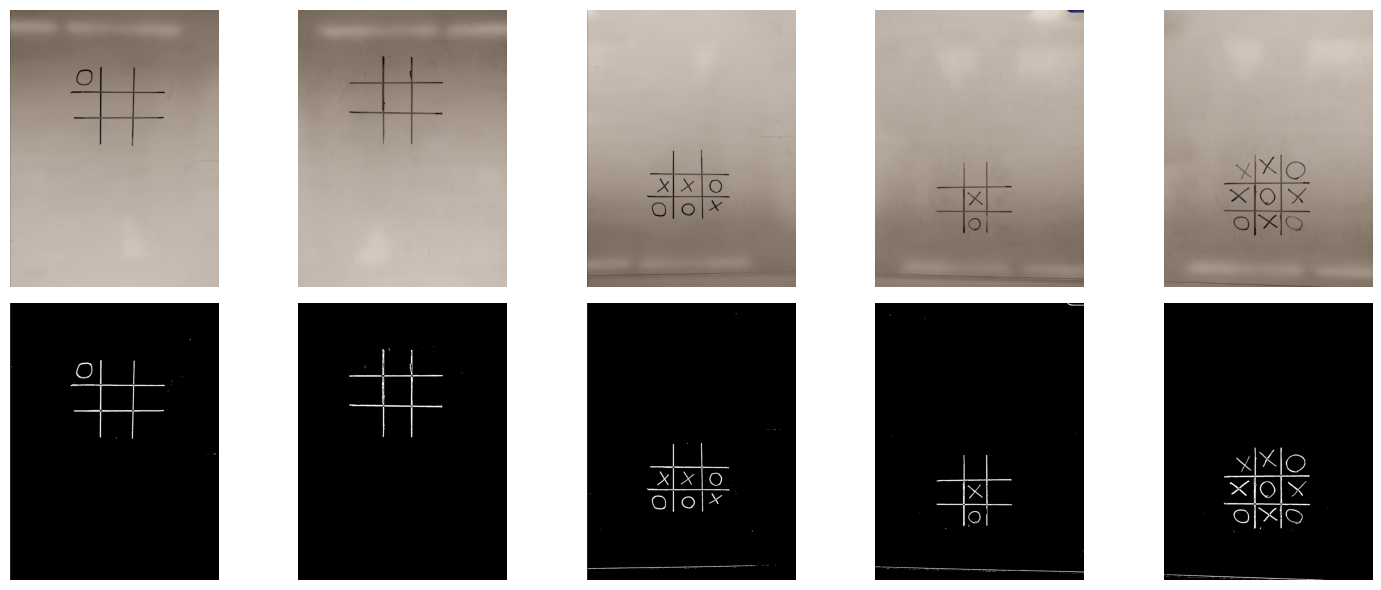

In [ ]:
start_idx = 5
end_idx = 10
num_display = end_idx - start_idx

plt.figure(figsize=(15, 6))

for i in range(start_idx, end_idx):
    # Load original image
    img_path = os.path.join(folder_path, image_files[i])
    img = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Preprocess using your function
    mask = preprocess_img(img)

    # Plot original
    plt.subplot(2, num_display, i - start_idx + 1)
    plt.imshow(img_rgb)
    plt.axis('off')
    if i == start_idx:
        plt.ylabel("Original", fontsize=12)

    # Plot preprocessed mask
    plt.subplot(2, num_display, i - start_idx + 1 + num_display)
    plt.imshow(mask, cmap='gray')
    plt.axis('off')
    if i == start_idx:
        plt.ylabel("Preprocessed", fontsize=12)

plt.tight_layout()
plt.show()


2-Boarder Lines

In [ ]:
import cv2
import numpy as np

def get_separated_lines(coords, min_dist=100, cluster_gap=30):
    """
    1. Clusters nearby lines.
    2. Picks the strongest cluster (most lines).
    3. Picks the next strongest cluster that is at least 'min_dist' away.
    """
    if not coords:
        return []

    coords = sorted(coords)
    groups = []
    current_group = [coords[0]]

    # 1. Cluster lines by proximity (cluster_gap)
    for c in coords[1:]:
        if c - current_group[-1] < cluster_gap:
            current_group.append(c)
        else:
            groups.append(current_group)
            current_group = [c]
    groups.append(current_group)

    # 2. Sort groups by strength (number of lines found in that spot)
    groups.sort(key=len, reverse=True)

    # Calculate average position for each group
    group_avgs = []
    for g in groups:
        avg = int(sum(g) / len(g))
        group_avgs.append(avg)

    # 3. Select the best two lines that are far apart
    if not group_avgs:
        return []

    # Pick the absolute strongest line first
    best_lines = [group_avgs[0]]

    # Look for the second line that is at least min_dist away
    for candidate in group_avgs[1:]:
        # Check distance against ALL currently selected lines
        if all(abs(candidate - selected) > min_dist for selected in best_lines):
            best_lines.append(candidate)
            if len(best_lines) == 2:
                break

    # If we still only have 1 line (e.g. the other grid line wasn't detected AT ALL),
    # we can't invent a second line safely. We just return what we have or handle it.
    return sorted(best_lines)

def detect_grid_lines_edges(img_mask, border_margin=100):
    h, w = img_mask.shape
    edges = cv2.Canny(img_mask, 50, 150)

    # Standard settings
    lines = cv2.HoughLinesP(edges, 1, np.pi/180, threshold=50, minLineLength=80, maxLineGap=10)

    h_coords, v_coords = [], []
    if lines is not None:
        for line in lines:
            x1,y1,x2,y2 = line[0]

            if abs(y2 - y1) < 5 and border_margin < y1 < h - border_margin:
                h_coords.append(y1)
            elif abs(x2 - x1) < 5 and border_margin < x1 < w - border_margin:
                v_coords.append(x1)


    # min_dist=100 ensures the two lines are at least 100px apart
    final_h = get_separated_lines(h_coords, min_dist=100)
    final_v = get_separated_lines(v_coords, min_dist=100)

    # Fallback only if we literally detected ZERO lines
    if len(final_h) < 2:
        # If we have 1, keep it. If 0, use center.
        if len(final_h) == 0: final_h = [h//3, h*2//3]
        elif len(final_h) == 1: final_h = [final_h[0], final_h[0] + 100] # dummy second line

    if len(final_v) < 2:
        if len(final_v) == 0: final_v = [w//3, w*2//3]
        elif len(final_v) == 1: final_v = [final_v[0], final_v[0] + 100]

    return final_h, final_v

Test

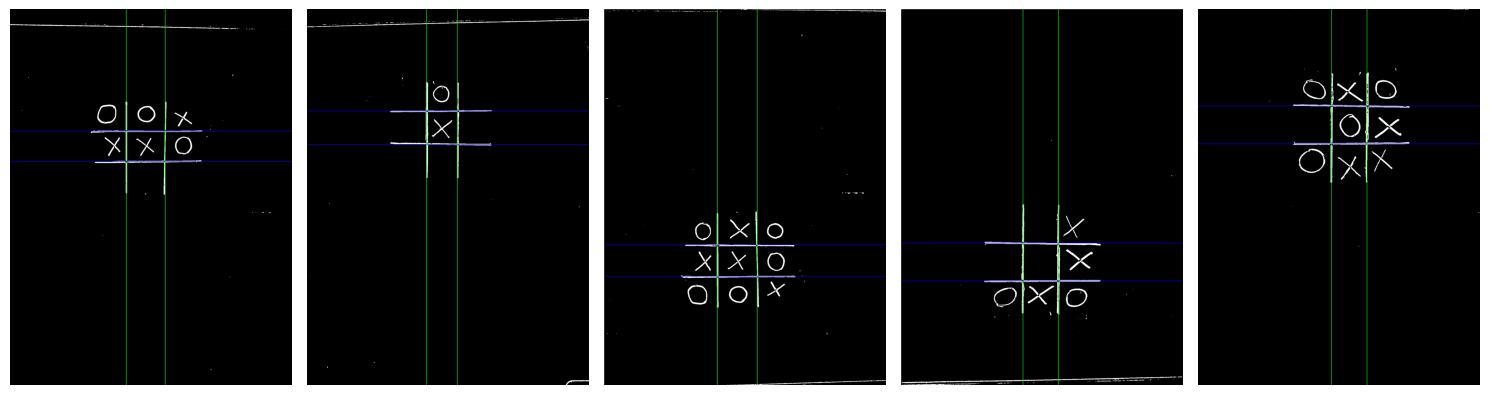

In [ ]:
start_idx = 0
end_idx = 5
num_display = end_idx - start_idx
plt.figure(figsize=(15, 10))

for i, idx in enumerate(range(start_idx, end_idx)):
    img_path = os.path.join(folder_path, image_files[idx])
    img = cv2.imread(img_path)
    if img is None:
        print(f"Could not read {image_files[idx]}")
        continue
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Preprocess
    mask = preprocess_img(img.copy())
    h_coords, v_coords = detect_grid_lines_edges(mask)

    # Convert binary mask to BGR for colored lines
    mask_bgr = cv2.cvtColor(mask, cv2.COLOR_GRAY2BGR)

    # Draw horizontal lines in blue
    for y in h_coords:
        cv2.line(mask_bgr, (0, y), (mask.shape[1], y), (255, 0, 0), 2)

    # Draw vertical lines in green
    for x in v_coords:
        cv2.line(mask_bgr, (x, 0), (x, mask.shape[0]), (0, 255, 0), 2)

    plt.subplot(2, num_display, i+1)
    plt.imshow(cv2.cvtColor(mask_bgr, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    if i == 0:
        plt.ylabel("Grid Lines", fontsize=12)

plt.tight_layout()
plt.show()


3-Cell Position 1–9

In [ ]:
def get_cells(h_coords, v_coords):
    """
    Returns 9 cells as (x1, y1, x2, y2)
    """
    # Approximate outer boundaries
    h_top = h_coords[0] - (h_coords[1]-h_coords[0])
    h_bottom = h_coords[1] + (h_coords[1]-h_coords[0])
    h_boundaries = [int(h_top), h_coords[0], h_coords[1], int(h_bottom)]

    v_left = v_coords[0] - (v_coords[1]-v_coords[0])
    v_right = v_coords[1] + (v_coords[1]-v_coords[0])
    v_boundaries = [int(v_left), v_coords[0], v_coords[1], int(v_right)]

    cells = []
    for i in range(3):
        for j in range(3):
            x1, x2 = v_boundaries[j], v_boundaries[j+1]
            y1, y2 = h_boundaries[i], h_boundaries[i+1]
            cells.append((x1, y1, x2, y2))
    return cells

Test

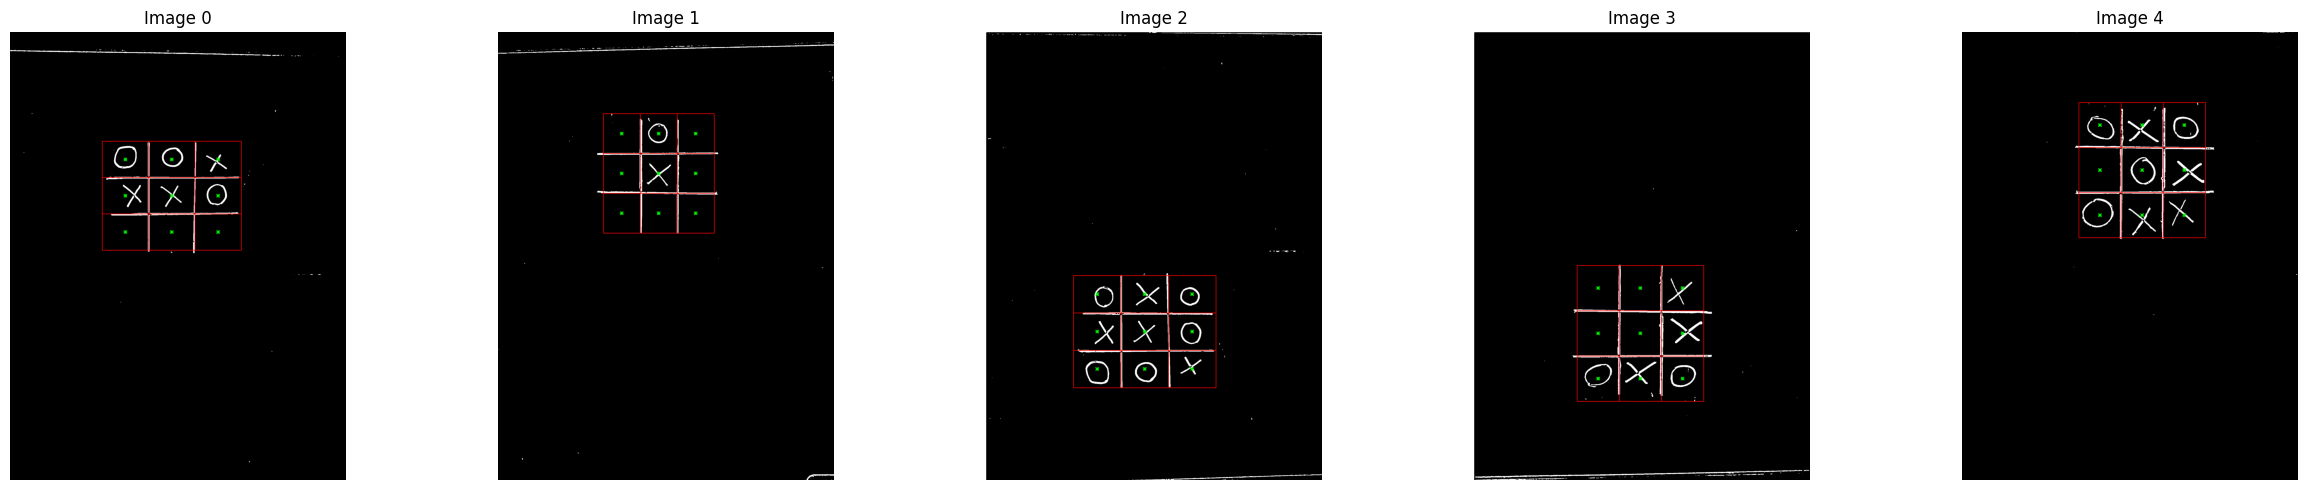

In [ ]:
start_idx = 0
end_idx = 5
num_images = end_idx - start_idx

plt.figure(figsize=(5 * num_images, 5))

for i, idx in enumerate(range(start_idx, end_idx)):
    img_path = os.path.join(folder_path, image_files[idx])
    img = cv2.imread(img_path)
    if img is None:
        print(f"Could not read {image_files[idx]}")
        continue

    # Preprocess
    mask= preprocess_img(img.copy())

    # Detect grid lines (2 horizontal, 2 vertical)
    h_coords, v_coords = detect_grid_lines_edges(mask)

    # Get cells
    cells = get_cells(h_coords, v_coords)

    # Draw rectangles and stars
    img_disp = cv2.cvtColor(mask, cv2.COLOR_GRAY2BGR)
    for x1, y1, x2, y2 in cells:
        cv2.rectangle(img_disp, (x1, y1), (x2, y2), (0, 0, 255), 2)
        cx, cy = (x1 + x2)//2, (y1 + y2)//2
        cv2.drawMarker(img_disp, (cx, cy), (0, 255, 0), markerType=cv2.MARKER_STAR, markerSize=15, thickness=2)

    # Plot side by side
    plt.subplot(1, num_images, i + 1)
    plt.imshow(cv2.cvtColor(img_disp, cv2.COLOR_BGR2RGB))
    plt.title(f"Image {idx}")
    plt.axis('off')

plt.tight_layout()
plt.show()

4-Identify X,O

In [ ]:
def classify_cells(mask, cells, edge_ratio=0.15, min_fill=0.03): # Lowered min_fill slightly
    symbols = []

    for (x1, y1, x2, y2) in cells:
        w, h = x2 - x1, y2 - y1

        # Crop the cell to ignore grid lines
        x_start = int(x1 + w * edge_ratio)
        x_end   = int(x2 - w * edge_ratio)
        y_start = int(y1 + h * edge_ratio)
        y_end   = int(y2 - h * edge_ratio)

        # Safety clamps
        x_start = max(0, x_start)
        y_start = max(0, y_start)
        x_end   = min(mask.shape[1], x_end)
        y_end   = min(mask.shape[0], y_end)

        cell_mask = mask[y_start:y_end, x_start:x_end]

        # Empty Check (Pixel Density)
        total_pixels = cell_mask.size
        white_pixels = cv2.countNonZero(cell_mask)

        if total_pixels == 0 or (white_pixels / total_pixels) < min_fill:
            symbols.append("Empty")
            continue

        # 2. Contour Analysis
        contours, _ = cv2.findContours(cell_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        large_contours = [c for c in contours if cv2.contourArea(c) > 20]

        if not large_contours:
            symbols.append("Empty")
            continue

        # Combine all disjoint parts (fixes broken chalk lines)
        all_points = np.vstack(large_contours)

        hull = cv2.convexHull(all_points)
        hull_area = cv2.contourArea(hull)

        (cx, cy), radius = cv2.minEnclosingCircle(all_points)
        circle_area = np.pi * (radius ** 2)

        if circle_area == 0:
            symbols.append("X") # Degenerate case (single point)
            continue

        # 3. Geometric Classification
        ratio = hull_area / circle_area

        # Use 0.70 as a safer cutoff
        if ratio > 0.70:
            symbols.append("O")
        else:
            symbols.append("X")

    return symbols

5-Visualize Result

In [ ]:
def visualize_results(img, mask, symbols, cells, pad=2):
    """
    Visualizes results with tight circles on the shapes.
    FIXED: Uses convex hull for tighter circle drawing.
    """
    img_cells = img.copy()
    img_circles = img.copy()
    mask_h, mask_w = mask.shape[:2]

    # --- LEFT IMAGE: Draw Numbered Cells ---
    for idx, (x1, y1, x2, y2) in enumerate(cells):
        cv2.rectangle(img_cells, (x1, y1), (x2, y2), (255, 255, 0), 2)
        cx, cy = int((x1 + x2) / 2), int((y1 + y2) / 2)
        txt = str(idx + 1)
        text_size = cv2.getTextSize(txt, cv2.FONT_HERSHEY_SIMPLEX, 1, 3)[0]
        text_x, text_y = cx - text_size[0] // 2, cy + text_size[1] // 2
        cv2.putText(img_cells, txt, (text_x, text_y), cv2.FONT_HERSHEY_SIMPLEX,
                    1, (0, 255, 255), 3)

    # --- RIGHT IMAGE: Draw TIGHT Classification Circles ---
    for idx, symbol in enumerate(symbols):
        if symbol == 'Empty' or symbol is None:
            continue

        x1, y1, x2, y2 = cells[idx]
        y1_p, y2_p = max(0, int(y1 - pad)), min(mask_h, int(y2 + pad))
        x1_p, x2_p = max(0, int(x1 - pad)), min(mask_w, int(x2 + pad))

        cell_mask = mask[y1_p:y2_p, x1_p:x2_p]
        contours, _ = cv2.findContours(cell_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        if not contours: continue

        # Combine all contours
        all_points = np.vstack([c.reshape(-1, 2) for c in contours])

        # --- THE FIX: Calculate Convex Hull FIRST ---
        hull = cv2.convexHull(all_points)

        # Find minimum enclosing circle around the HULL for a tight fit
        (lcx, lcy), radius = cv2.minEnclosingCircle(hull)

        global_cx = int(x1_p + lcx)
        global_cy = int(y1_p + lcy)
        radius = int(radius)

        color = (0, 0, 255) if symbol == 'X' else (0, 255, 0)
        cv2.circle(img_circles, (global_cx, global_cy), radius, color, 3)

    # --- PLOTTING ---
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(img_cells, cv2.COLOR_BGR2RGB))
    plt.title("Detected Cells (Numbered)")
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(img_circles, cv2.COLOR_BGR2RGB))
    plt.title("Classified Result")
    plt.axis('off')
    plt.tight_layout()
    plt.show()

Final Testing (Putting it all together)

Image 38 symbols: ['Empty', 'Empty', 'Empty', 'Empty', 'Empty', 'X', 'X', 'O', 'O']


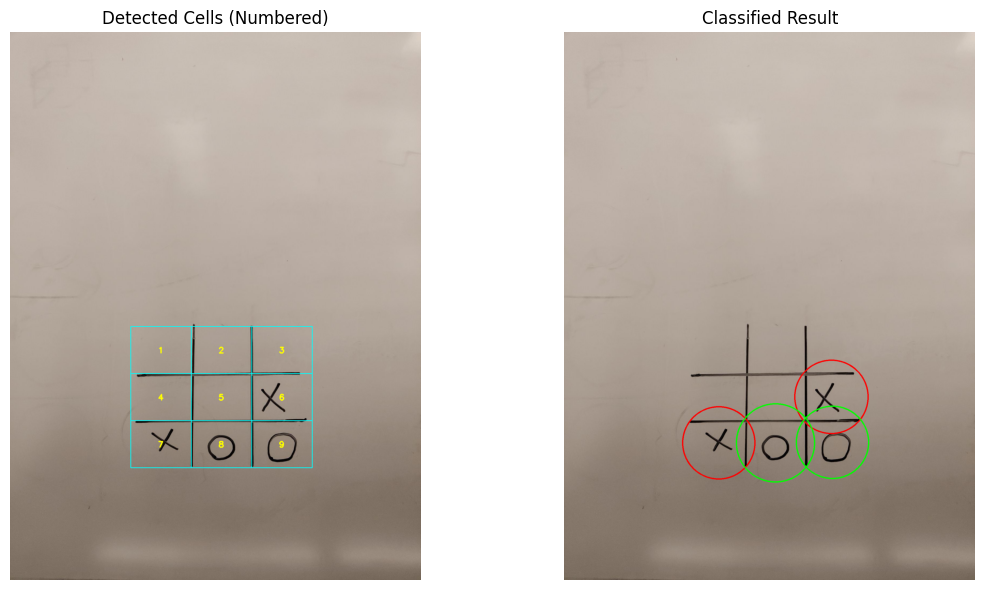

Image 39 symbols: ['O', 'Empty', 'O', 'Empty', 'Empty', 'X', 'Empty', 'Empty', 'X']


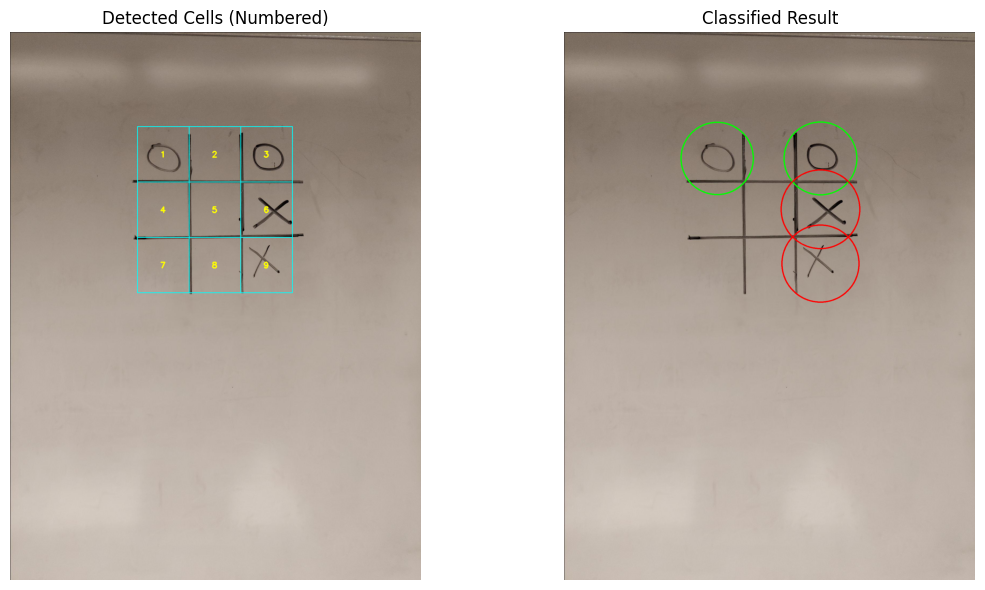

Image 40 symbols: ['Empty', 'Empty', 'Empty', 'Empty', 'Empty', 'Empty', 'Empty', 'Empty', 'Empty']


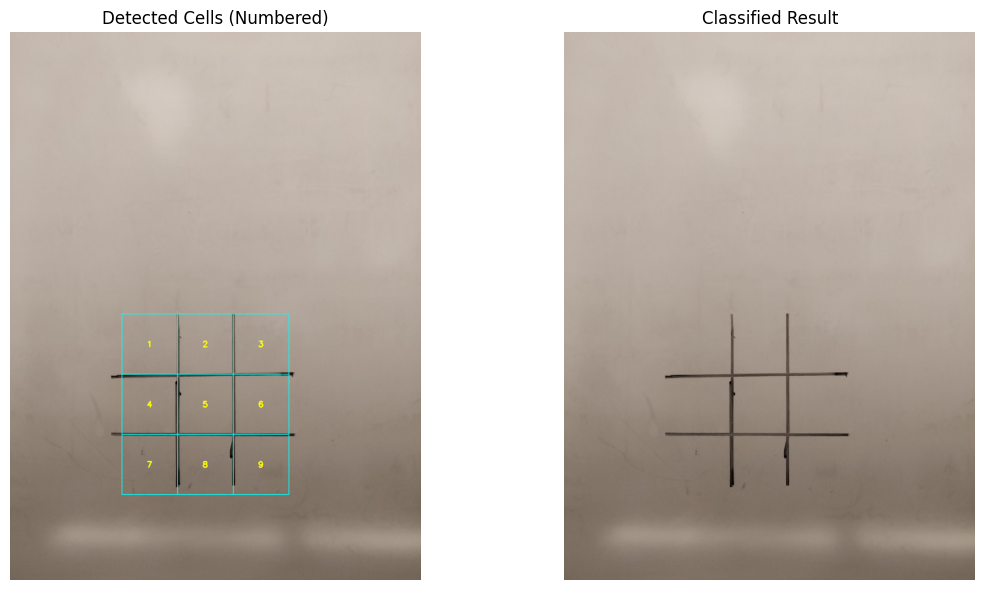

Image 41 symbols: ['O', 'X', 'Empty', 'X', 'X', 'O', 'O', 'O', 'X']


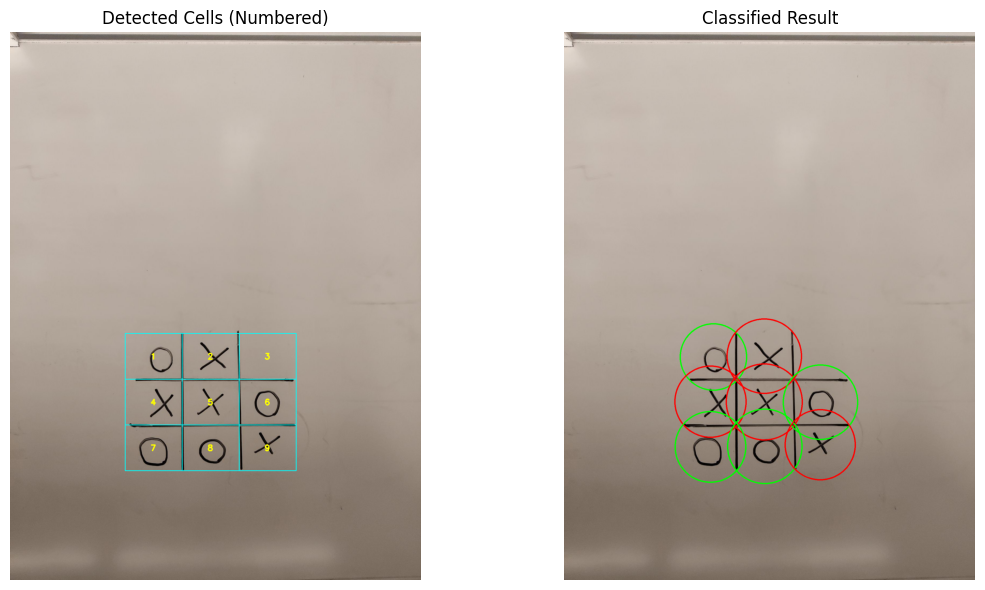

Image 42 symbols: ['Empty', 'Empty', 'Empty', 'Empty', 'X', 'Empty', 'X', 'O', 'Empty']


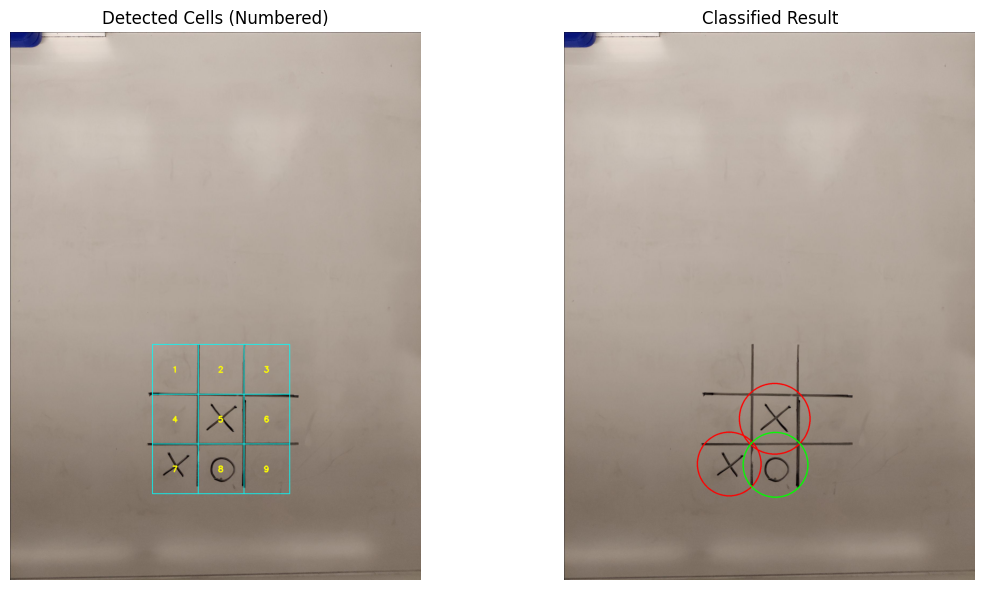

In [ ]:
start_idx = 38
end_idx = 43

for i in range(start_idx, end_idx):

    img_path = os.path.join(folder_path, image_files[i])
    img = cv2.imread(img_path)
    if img is None:
        print(f"Could not read {image_files[i]}")
        continue

    # 1. Preprocess
    mask= preprocess_img(img.copy()) # Ignore the 'gray' image, as it's not the margin

    # 2. Detect grid lines
    h_coords, v_coords = detect_grid_lines_edges(mask)

    # 3. Get cell coordinates
    cells = get_cells(h_coords, v_coords)

    # 4. Detect symbols in each cell
    symbols = classify_cells(mask, cells)

    print(f"Image {i} symbols: {symbols}")

    # 5. Visualize
    visualize_results(img, mask, symbols, cells, 5,) # Pass a scalar value (e.g., 5) for margin

Evaluate

In [ ]:
def evaluate_performance(user_results, ground_truth):
    rows = []
    x_error_sum = 0
    o_error_sum = 0
    N = len(ground_truth)

    print(f"Evaluating {N} images...")

    for filename in ground_truth:
        gt_data = ground_truth[filename]

        # Ground truth
        gt_x_pos = gt_data.get("x", [])
        gt_o_pos = gt_data.get("o", [])

        gt_x_count = len(gt_x_pos)
        gt_o_count = len(gt_o_pos)

        # Predictions
        preds = user_results.get(filename, [])

        pred_x_pos = [i + 1 for i, s in enumerate(preds) if s == "X"]
        pred_o_pos = [i + 1 for i, s in enumerate(preds) if s == "O"]

        pred_x_count = len(pred_x_pos)
        pred_o_count = len(pred_o_pos)

        # Squared error
        x_error_sum += (gt_x_count - pred_x_count) ** 2
        o_error_sum += (gt_o_count - pred_o_count) ** 2

        rows.append({
            "Image Name": filename,
            "Xs Positions (True)": gt_x_pos,
            "Xs Positions (Output)": pred_x_pos,
            "Os Positions (True)": gt_o_pos,
            "Os Positions (Output)": pred_o_pos
        })

    # RMSE
    rmse_x = np.sqrt(x_error_sum / N)
    rmse_o = np.sqrt(o_error_sum / N)

    df = pd.DataFrame(rows)

    # Append RMSE row (same style as PDF)
    df.loc[len(df)] = [
        "RMSE", "", f"{rmse_x:.4f}", "", f"{rmse_o:.4f}"
    ]

    return df

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving GT.json to GT.json


In [ ]:
import json

with open("GT.json", "r") as f:
    ground_truth = json.load(f)

print(ground_truth.keys())  # Check the filenames loaded


dict_keys(['IMG_20220614_014432_jpg.rf.155ec4625b1f3d7c9d82495bf9146065.jpg', 'IMG_20220614_014451_jpg.rf.6af0a1bcb1685e6b511e001241635f43.jpg', 'IMG_20220613_231107_jpg.rf.a0928dbd4333d7f4d28dfe9c4f6e8de2.jpg', 'IMG_20220614_014451_jpg.rf.48b0c662ed44ef43ac70ac30e1ff2196.jpg', 'IMG_20220614_014451_jpg.rf.ee5953dd4e6d9bb3b3b61b93202efc28.jpg', 'IMG_20220614_014419_jpg.rf.07103d2129e9ff3533c75f90fcd58bda.jpg', 'IMG_20220613_231218_jpg.rf.771733e791977c4cf00b58ffd26dd8b3.jpg', 'IMG_20220613_231037_jpg.rf.d410cba32b8c69092eea348443df19f2.jpg', 'IMG_20220614_014228_jpg.rf.40dab356f774f1e736345430698fb242.jpg', 'IMG_20220613_231029_jpg.rf.d2e28a8960f554383d4bd556eb4f2297.jpg', 'IMG_20220614_014150_jpg.rf.2f63ae1320a0b001aec5fc892ca8c86f.jpg', 'IMG_20220614_014222_jpg.rf.be5bed4e03b93ecc36e15013a4de68f3.jpg', 'IMG_20220613_231524_jpg.rf.d3afa45d405ee555a30804db403805bb.jpg', 'IMG_20220613_231037_jpg.rf.285df21bb1e105adbb0bd43b350f5216.jpg', 'IMG_20220614_014432_jpg.rf.52368bb76804524b914c2e6

In [ ]:
# Dictionary to store results
my_results = {}

for i, filename in enumerate(image_files):
    img_path = os.path.join(folder_path, filename)
    img = cv2.imread(img_path)

    if img is None:
        print(f"Could not read {filename}")
        continue

    # 1. Preprocess
    mask = preprocess_img(img.copy())

    # 2. Detect grid lines
    h_coords, v_coords = detect_grid_lines_edges(mask)

    # 3. Get cell coordinates
    cells = get_cells(h_coords, v_coords)

    # 4. Detect symbols in each cell
    symbols = classify_cells(mask, cells)

    # 5. Save results
    my_results[filename] = symbols

In [ ]:
df_report = evaluate_performance(my_results, ground_truth)
df_report

Evaluating 64 images...


,Image Name,Xs Positions (True),Xs Positions (Output),Os Positions (True),Os Positions (Output)
0,IMG_20220614_014432_jpg.rf.155ec4625b1f3d7c9d8...,"[5, 7]","[5, 7]",[8],[8]
1,IMG_20220614_014451_jpg.rf.6af0a1bcb1685e6b511...,"[3, 5, 9]","[3, 5, 9]","[2, 7]","[2, 7]"
2,IMG_20220613_231107_jpg.rf.a0928dbd4333d7f4d28...,"[2, 4, 5, 9]","[2, 4, 5, 9]","[1, 3, 6, 7, 8]","[1, 3, 6, 7, 8]"
3,IMG_20220614_014451_jpg.rf.48b0c662ed44ef43ac7...,"[1, 5, 7]","[1, 5, 7]","[3, 8]","[3, 8]"
4,IMG_20220614_014451_jpg.rf.ee5953dd4e6d9bb3b3b...,"[3, 5, 9]","[3, 5, 9]","[2, 7]","[2, 7]"
...,...,...,...,...,...
60,IMG_20220614_014228_jpg.rf.0e39a34a1abe2eb9a53...,"[2, 4, 6, 7, 8]","[2, 4, 6, 7, 8]","[1, 3, 5, 9]","[1, 3, 5, 9]"
61,IMG_20220613_231218_jpg.rf.f0c9cabc1b05c7ca5d7...,[],[],"[1, 2, 3, 4, 5, 6, 7, 8, 9]","[1, 2, 3, 4, 5, 6, 7, 8, 9]"
62,IMG_20220614_014150_jpg.rf.bd9b662d99b9c498729...,[1],[1],[9],[9]
63,IMG_20220613_231005_jpg.rf.34311712876f4c5ea85...,[],[],[1],[1]


In [ ]:
df_report.to_csv("evaluation_report.csv", index=False)

In [ ]:
from google.colab import files
files.download("evaluation_report.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>